# Import Libraries and Load Data

In [23]:
import pandas as pd
from rich.console import Console

console = Console()

We use `squeeze=True` to indicate that our data has only one column and we want to retrieve a `pandas.Series` (see [here](https://machinelearningmastery.com/load-explore-time-series-data-python/))

In [2]:
daily_rentals = pd.read_csv(
    "../data/bikemi_csv/daily_outflow.csv", index_col=[0], parse_dates=[0], squeeze=True
).asfreq(freq="D")

print(f"Our data is a {type(daily_rentals)}")

daily_rentals

Our data is a <class 'pandas.core.series.Series'>


giorno_partenza
2019-01-01     831
2019-01-02    3512
2019-01-03    4126
2019-01-04    4201
2019-01-05    2875
              ... 
2019-12-27    2995
2019-12-28    1944
2019-12-29    1269
2019-12-30    2698
2019-12-31    2126
Freq: D, Name: count, Length: 365, dtype: int64

We also need to make sure our index has a frequency - which we did with `.asfreq("D")` above:

In [3]:
daily_rentals.index

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='giorno_partenza', length=365, freq='D')

# Naive forecaster

We need to establish a benchmark:

In [4]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

We will be using a Seasonal Naive Forecaster (link Hyndman) where the predicted value is the one of the last seasonal value (i.e., 7 days before):

In [5]:
y_train, y_test = temporal_train_test_split(daily_rentals)

# uses all of the test set as forecasting horizon
fh = ForecastingHorizon(y_test.index, is_relative=False)

# naive forecaster model definition
naive_forecaster = NaiveForecaster(strategy="last", sp=7)  # weekly seasonal periodicity

# naive forecaster model fitting
naive_forecaster.fit(y_train)

# naive forecaster predictions
y_pred = naive_forecaster.predict(fh)

# naive forecaster error
mean_absolute_percentage_error(y_test, y_pred)

/Users/luca/.pyenv/versions/miniconda3-latest/envs/bikemi/lib/python3.8/site-packages/sktime/forecasting/base/_fh.py:451: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if not hasattr(cutoff, "freqstr") or cutoff.freqstr is None:
/Users/luca/.pyenv/versions/miniconda3-latest/envs/bikemi/lib/python3.8/site-packages/sktime/forecasting/base/_fh.py:461: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  assert cutoff.freqstr == index.freqstr
/Users/luca/.pyenv/versions/miniconda3-latest/envs/bikemi/lib/python3.8/site-packages/sktime/utils/datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
/Users/luca/.pyenv/versions/miniconda3-latest/envs/bikemi/lib/python3.8/site-packages/sktime/utils/datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr
/Users/luca/.pyenv/vers

0.6406029062204276

Our model has 64% MAPE - whereas one might have expected something more. Let's plot it to see the differences:

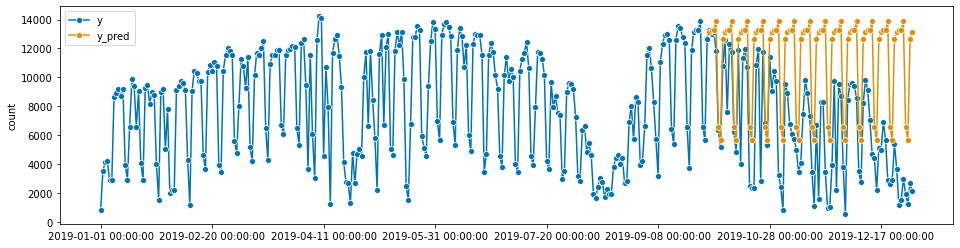

In [6]:
from sktime.utils.plotting import plot_series

plot_series(daily_rentals, y_pred, labels=["y", "y_pred"]);

Maybe we can build a more realiable forecaster by taking first differences:

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='count'>)

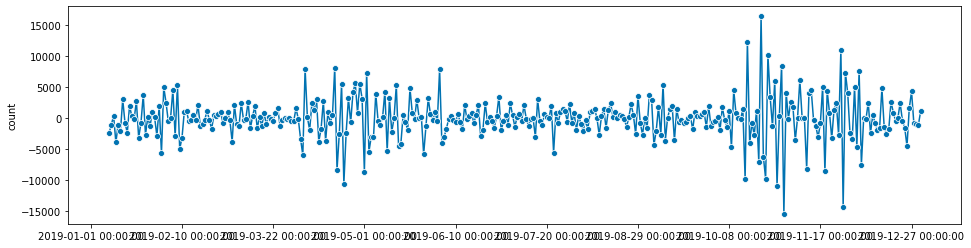

In [15]:
plot_series(daily_rentals.diff(1).diff(7))

In [27]:
from statsmodels.tsa.stattools import adfuller

adfuller_results = adfuller(daily_rentals.diff(1).diff(7).dropna(), regression="ct")

console.print(
    f"Advanced Dickey-Fuller p-value is {adfuller_results[1]:.2%}: "
    f'{"there is a unit root - i.e. the series is non-stationary" if adfuller_results[1] > 0.05 else "there is no unit root - the series is stationary"}'
)

Advanced Dickey-Fuller p-value is 0.00%: there is no unit root - the series is stationary

* [This](https://www.sciencedirect.com/science/article/pii/S0169207000000674) Explains well how auto models are used
* [Theta-forecaster](https://www.sciencedirect.com/science/article/pii/S0169207000000662) Exploits seasonal patterns

As explained in the [official documentation](https://www.sktime.org/en/latest/api_reference/modules/auto_generated/sktime.forecasting.arima.AutoARIMA.html?highlight=seasonal%20decomposition),

The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model. This process is based on the commonly-used R function, forecast::auto.arima [3].

Auto-ARIMA works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper-parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In order to find the best model, auto-ARIMA optimizes for a given information_criterion, one of (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’) (Akaike Information Criterion, Corrected Akaike Information Criterion, Bayesian Information Criterion, Hannan-Quinn Information Criterion, or “out of bag”–for validation scoring–respectively) and returns the ARIMA which minimizes the value.

Note that due to stationarity issues, auto-ARIMA might not find a suitable model that will converge. If this is the case, a ValueError will be thrown suggesting stationarity-inducing measures be taken prior to re-fitting or that a new range of order values be selected. Non- stepwise (i.e., essentially a grid search) selection can be slow, especially for seasonal data. Stepwise algorithm is outlined in Hyndman and Khandakar (2008).